In [142]:
options(repr.plot.width=15, repr.plot.height=10)

In [143]:
library(plyr)
library(ggplot2)
library(corpcor)
library(evolqg)
library(tidyverse)
library(cowplot)
library(patchwork)
library(psych)
library(doMC)
registerDoMC(8)

In [175]:
#data_folder = "/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices"
data_folder = "./"
dir(data_folder)

[1] "__pycache__"                                                                     
 [2] "body_high-block.1.RData"                                                         
 [3] "body_low-block.1.RData"                                                          
 [4] "body_table_wcgna_fdrLevel-1e-05.csv"                                             
 [5] "body_trimmed-block.1.RData"                                                      
 [6] "Control-BodyHead - NetworkStats.ipynb"                                           
 [7] "Correlations between head and body - The SVA trials.ipynb"                       
 [8] "datafile.txt"                                                                    
 [9] "Decoherence for the masses.ipynb"                                                
[10] "export_blocks.py"                                                                
[11] "FETCH_HEAD"                                                                      
[12] "fit_sbm.py"                                                                      
[13] "gene_network_statistics_test.csv"                                                
[14] "Graph Tool - Control-Body-HighQC - Graph Structure .ipynb"                       
[15] "Graph tool network inference.ipynb"                                              
[16] "Graph Tool Small network Resource Paper - Control-BodyHead - Make Networks.ipynb"
[17] "GraphTool-Control-Head-HighQC-NullModels.ipynb"                                  
[18] "GraphTool-ResourcePaper-Control-Body-HighQC.ipynb"                               
[19] "GraphTool-ResourcePaper-Control-Head-HighQC.ipynb"                               
[20] "head_high-block.1.RData"                                                         
[21] "head_low-block.1.RData"                                                          
[22] "head_table_wcgna_fdrLevel-1e-05.csv"                                             
[23] "head_trimmed-block.1.RData"                                                      
[24] "make_network.py"                                                                 
[25] "run_inital_sbm_head.sh"                                                          
[26] "run_initial_sbm_body.sh"                                                         
[27] "run_sbm_body.sh"                                                                 
[28] "run_sbm_head.sh"                                                                 
[29] "test.csv"                                                                        
[30] "trim_networks.py"                                                                
[31] "WGCNA last chance.ipynb"

In [150]:
expr_list = list(body_low = t(read.table(file.path(data_folder, 
                                             "VOOMCounts_CPM1_body_ctrl_onlygenesinmainchr_939ind_covfree_Jul21.21.txt"), 
                                   row.names = 1)),
                 body_high = t(read.table(file.path(data_folder, 
                                             "VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21.txt"), 
                                   row.names = 1)), 
                 head_low = t(read.table(file.path(data_folder, 
                                             "VOOMCounts_CPM1_head_ctrl_onlygenesinmainchr_940ind_covfree_Jul21.21.txt"), 
                                   row.names = 1)),
                 head_high = t(read.table(file.path(data_folder, 
                                             "VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21.txt"), 
                                   row.names = 1)))
rownames(expr_list[[1]]) = gsub("^X", "", rownames(expr_list[[1]]))
rownames(expr_list[[2]]) = gsub("^X", "", rownames(expr_list[[2]]))
rownames(expr_list[[3]]) = gsub("^X", "", rownames(expr_list[[3]]))
rownames(expr_list[[4]]) = gsub("^X", "", rownames(expr_list[[4]]))

ERROR: Error in expr_list[[5]]: subscript out of bounds


In [151]:
gene_list = lapply(expr_list, colnames)
common_genes_low = gene_list$body_low[gene_list$body_low %in% gene_list$head_low]
common_genes_high = gene_list$body_high[gene_list$body_high %in% gene_list$head_high]
common_genes = common_genes_high[common_genes_high %in% common_genes_low]

In [152]:
if(!require(WGCNA)){BiocManager::install("WGCNA"); library(WGCNA)}
if(!require(doMC)){install.packages("doMC"); library(doMC)}   
if(!require(tictoc)){install.packages("tictoc"); library(tictoc)}   
library(foreach)
registerDoMC(8)

In [154]:
source("https://raw.githubusercontent.com/RujiaDai/csuWGCNA/master/source%20code/Hadjacency.r")

In [155]:
source("https://raw.githubusercontent.com/RujiaDai/csuWGCNA/master/source%20code/hpickSoftThreshold.r")

In [157]:
soft_thresh = llply(expr_list[c("head_high", "body_high")], 
                    pickSoftThreshold, corFnc = "bicor", verbose = 5,
                    networkType = "signed", .parallel = TRUE)

In [158]:
soft_thresh = llply(expr_list[c("head_high", "body_high")], 
                    hpickSoftThreshold, corFnc = "bicor", verbose = 5,
                    networkType = "hybrid2", .parallel = TRUE)

In [159]:
soft_thresh

Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7065889,-24.936819,0.8985131,3068.6607359,3.055338e+03,3336.12891
2,0.7793547,-13.252516,0.9184770,1696.1855011,1.678903e+03,2029.02628
3,0.8415483,-9.215357,0.9355672,943.3972211,9.263541e+02,1259.11643
4,0.8878532,-7.175034,0.9429831,528.3364582,5.135950e+02,799.41545
5,0.9234108,-5.926111,0.9513215,298.1780504,2.860083e+02,520.83114
6,0.9491075,-5.054681,0.9586601,169.7524969,1.600072e+02,349.26027
7,0.9659590,-4.417435,0.9654313,97.6000463,8.999987e+01,242.48232
8,0.9719068,-3.889601,0.9648508,56.7558573,5.087410e+01,174.26945
9,0.9741088,-3.450522,0.9669820,33.4405995,2.890899e+01,129.74975


In [153]:
hard_thresh = llply(expr_list[c("head_high", "body_high")], 
                    pickHardThreshold, cutVector = seq(0.15, 0.4, by = 0.01), .parallel = TRUE)

In [126]:
hard_thresh

Cut,p.value,SFT.R.sq,slope.,truncated.R.2,mean.k.,median.k.,max.k.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.15,2.787317e-02,0.1757187,-0.6939086,0.8528803,1381.27973,1312.5,3173
0.16,1.889846e-02,0.2923381,-0.9440330,0.8281014,1224.26074,1143.5,3031
0.17,1.254767e-02,0.3764734,-1.0563724,0.8404301,1081.91941,993.0,2885
0.18,8.155203e-03,0.4569501,-1.1160217,0.8655730,953.98388,855.0,2732
0.19,5.186543e-03,0.5228142,-1.2015370,0.8681499,839.21741,733.0,2581
0.20,3.226461e-03,0.5581870,-1.2817092,0.8556570,736.93768,626.0,2441
0.21,1.962503e-03,0.6123195,-1.2966322,0.8713708,646.24355,529.5,2287
0.22,1.166692e-03,0.6343460,-1.3602519,0.8662815,566.10494,444.0,2159
0.23,6.776178e-04,0.6440664,-1.4321498,0.8597470,495.18517,369.0,2044


In [17]:
#k=softConnectivity(datE=expr_list$head_high, power=2)

In [84]:
blockWise_power2 = llply(names(expr_list),
                  function(x) {
                      blockwiseModules(expr_list[[x]], 
                                        power = 2,
                                        TOMType = "signed", minModuleSize = 10,
                                        reassignThreshold = 0, mergeCutHeight = 0.25,
                                        numericLabels = TRUE, pamRespectsDendro = FALSE,
                                        maxBlockSize = 10000,
                                        saveTOMs = TRUE,
                                        saveTOMFileBase = x,
                                        verbose = 3)}, .parallel = TRUE)

In [168]:
blockWise_power2_spearman = llply(names(expr_list),
                  function(x) {
                      blockwiseModules(expr_list[[x]], 
                                        power = 2,
                                        TOMType = "signed", minModuleSize = 10,
                                        reassignThreshold = 0, mergeCutHeight = 0.25,
                                        numericLabels = TRUE, pamRespectsDendro = FALSE,
                                        maxBlockSize = 10000,
                                        saveTOMs = TRUE,
                                        saveTOMFileBase = x,  corType = "bicor",
                                        verbose = 3)}, .parallel = TRUE)

In [170]:
names(blockWise_power2) = names(expr_list)
names(blockWise_power2_spearman) = names(expr_list)

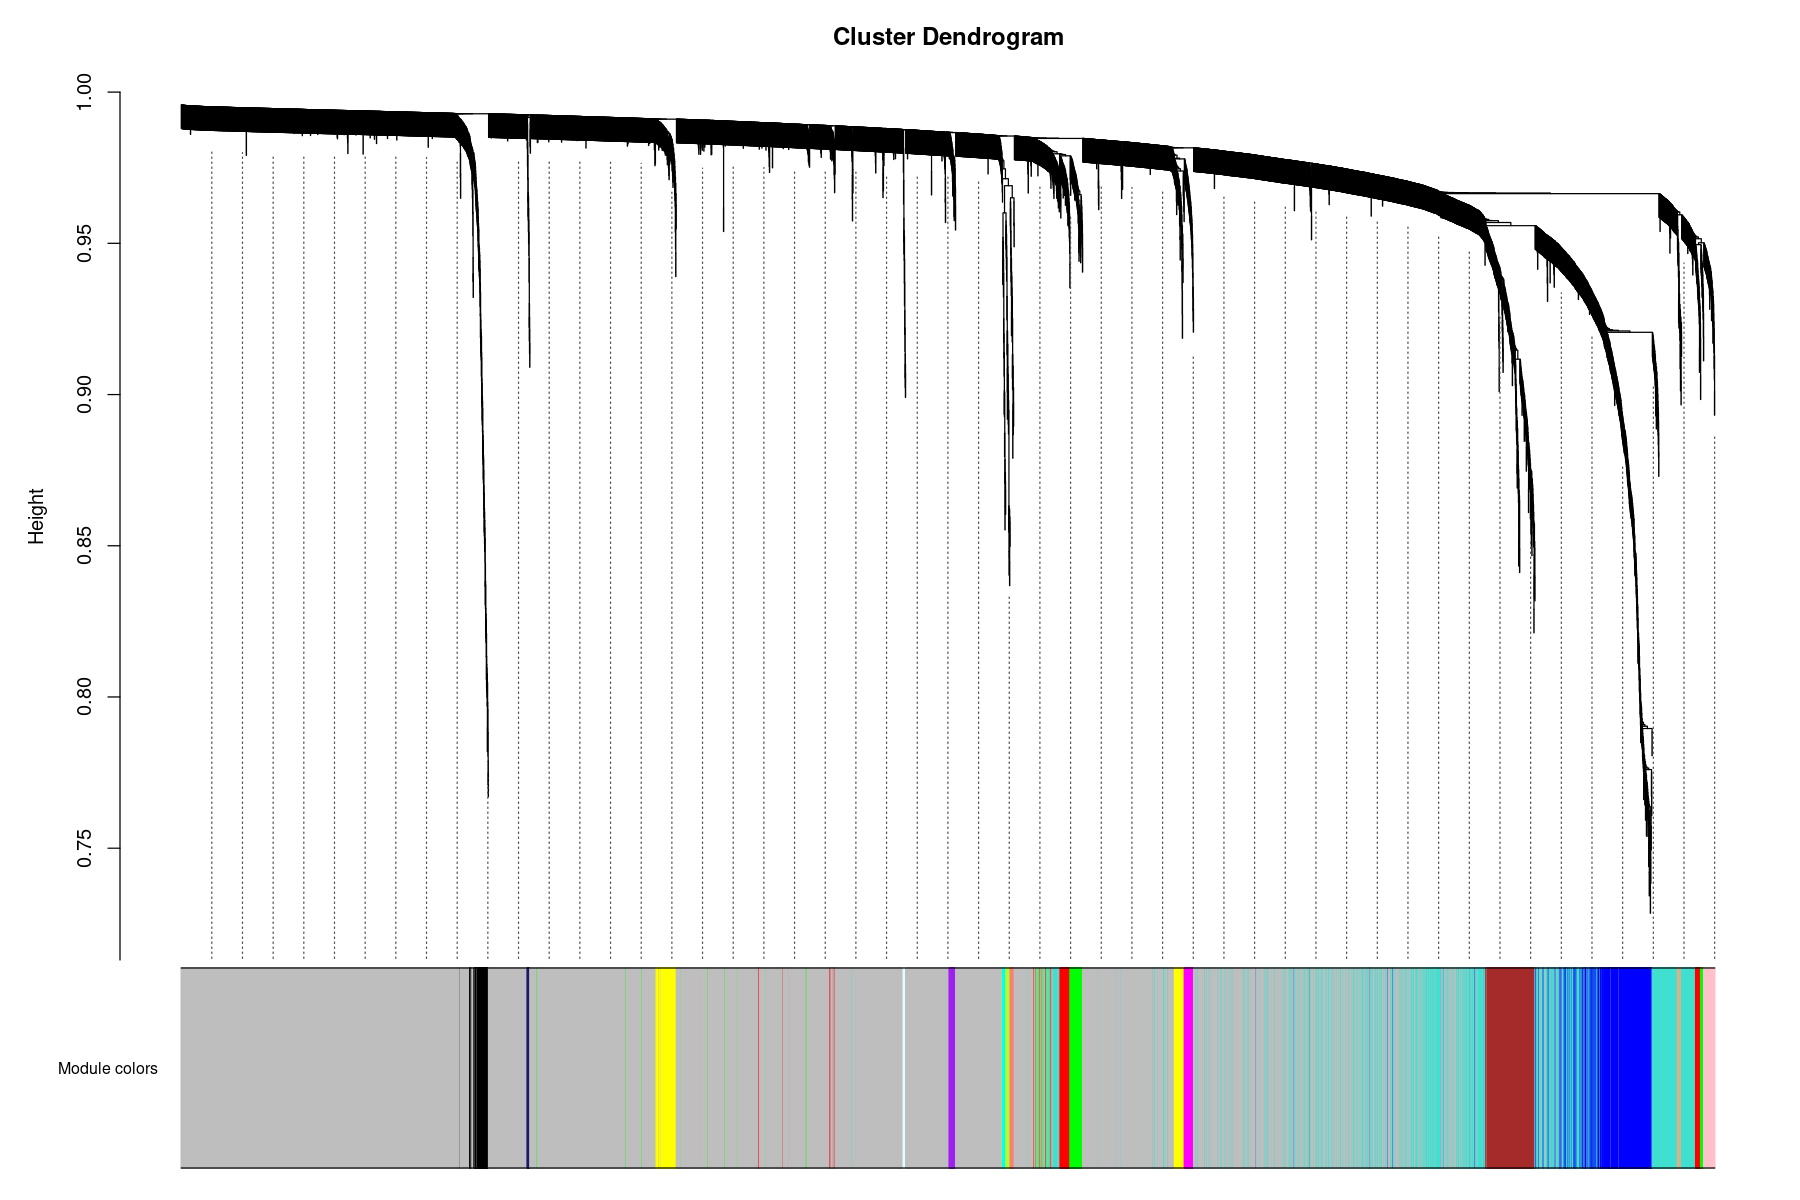

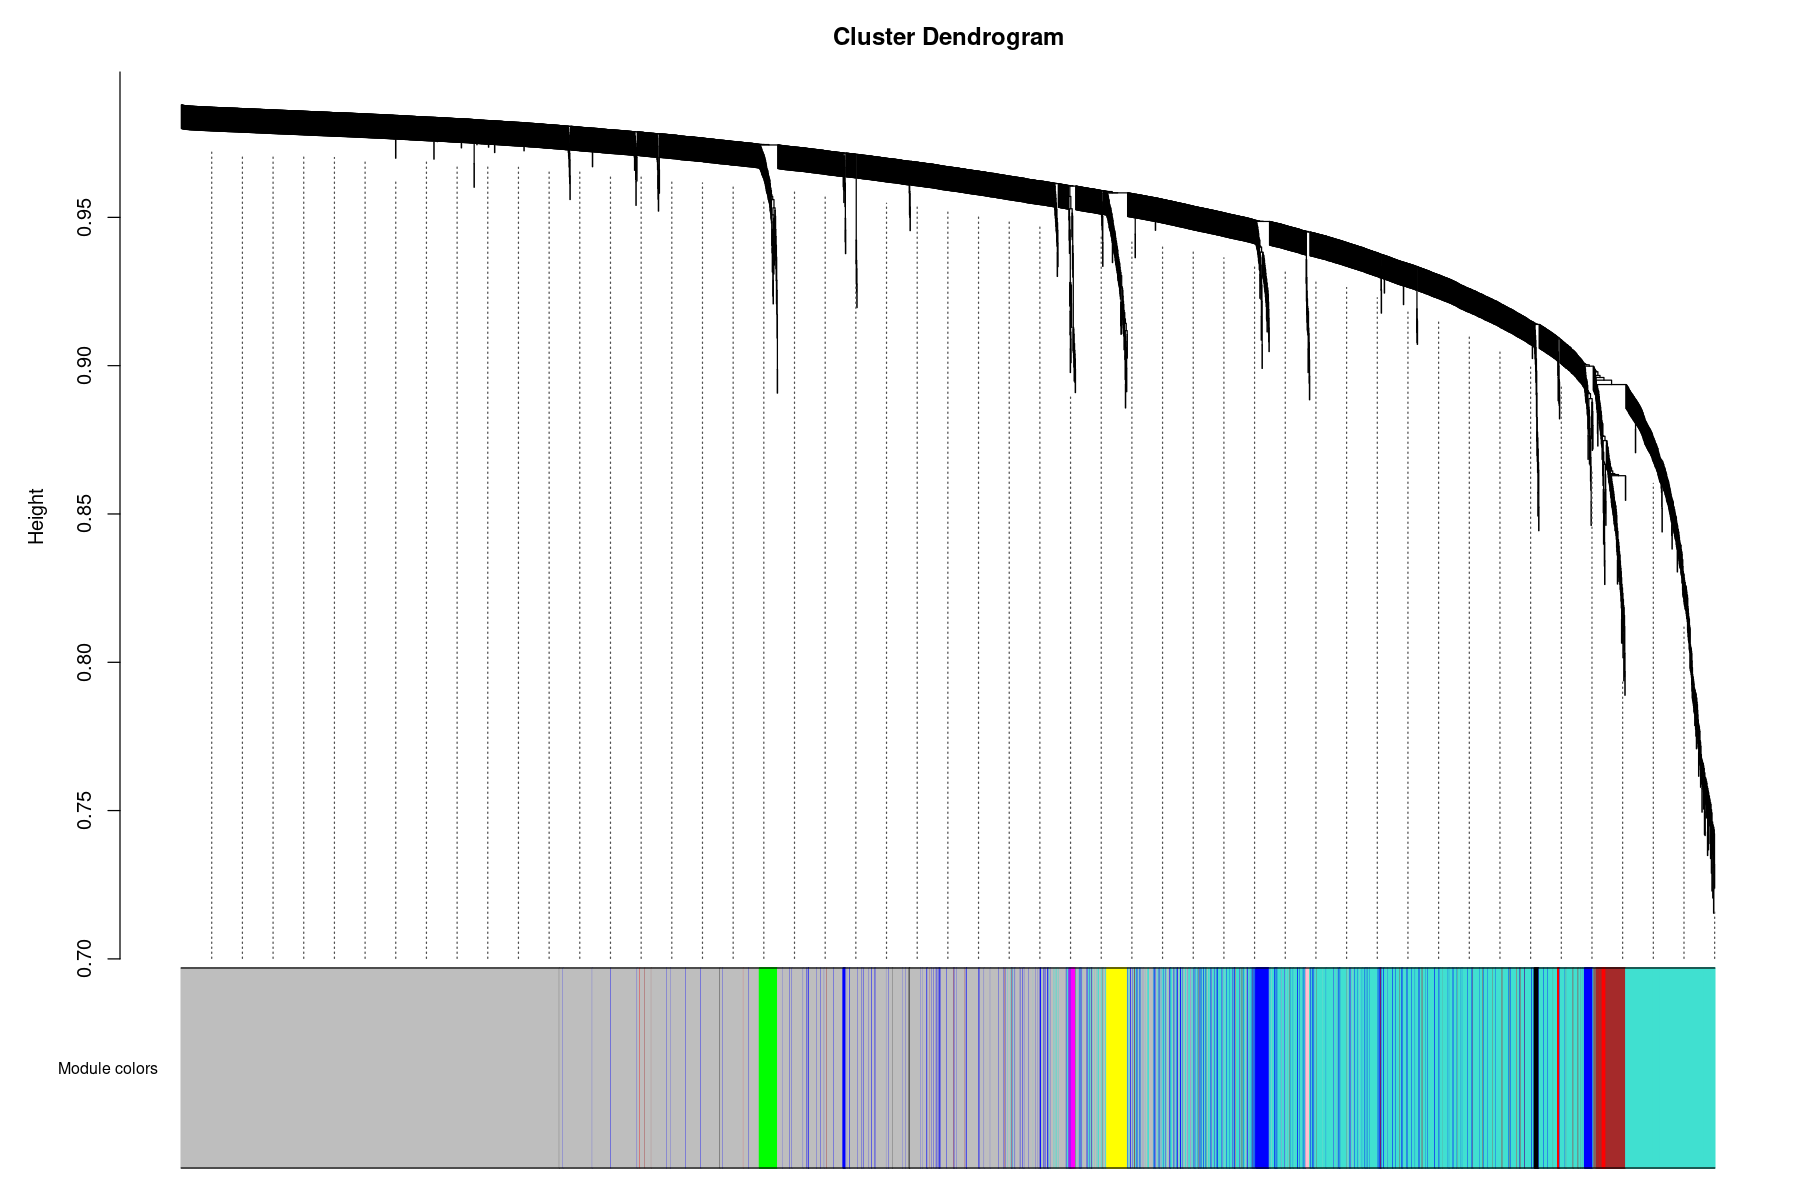

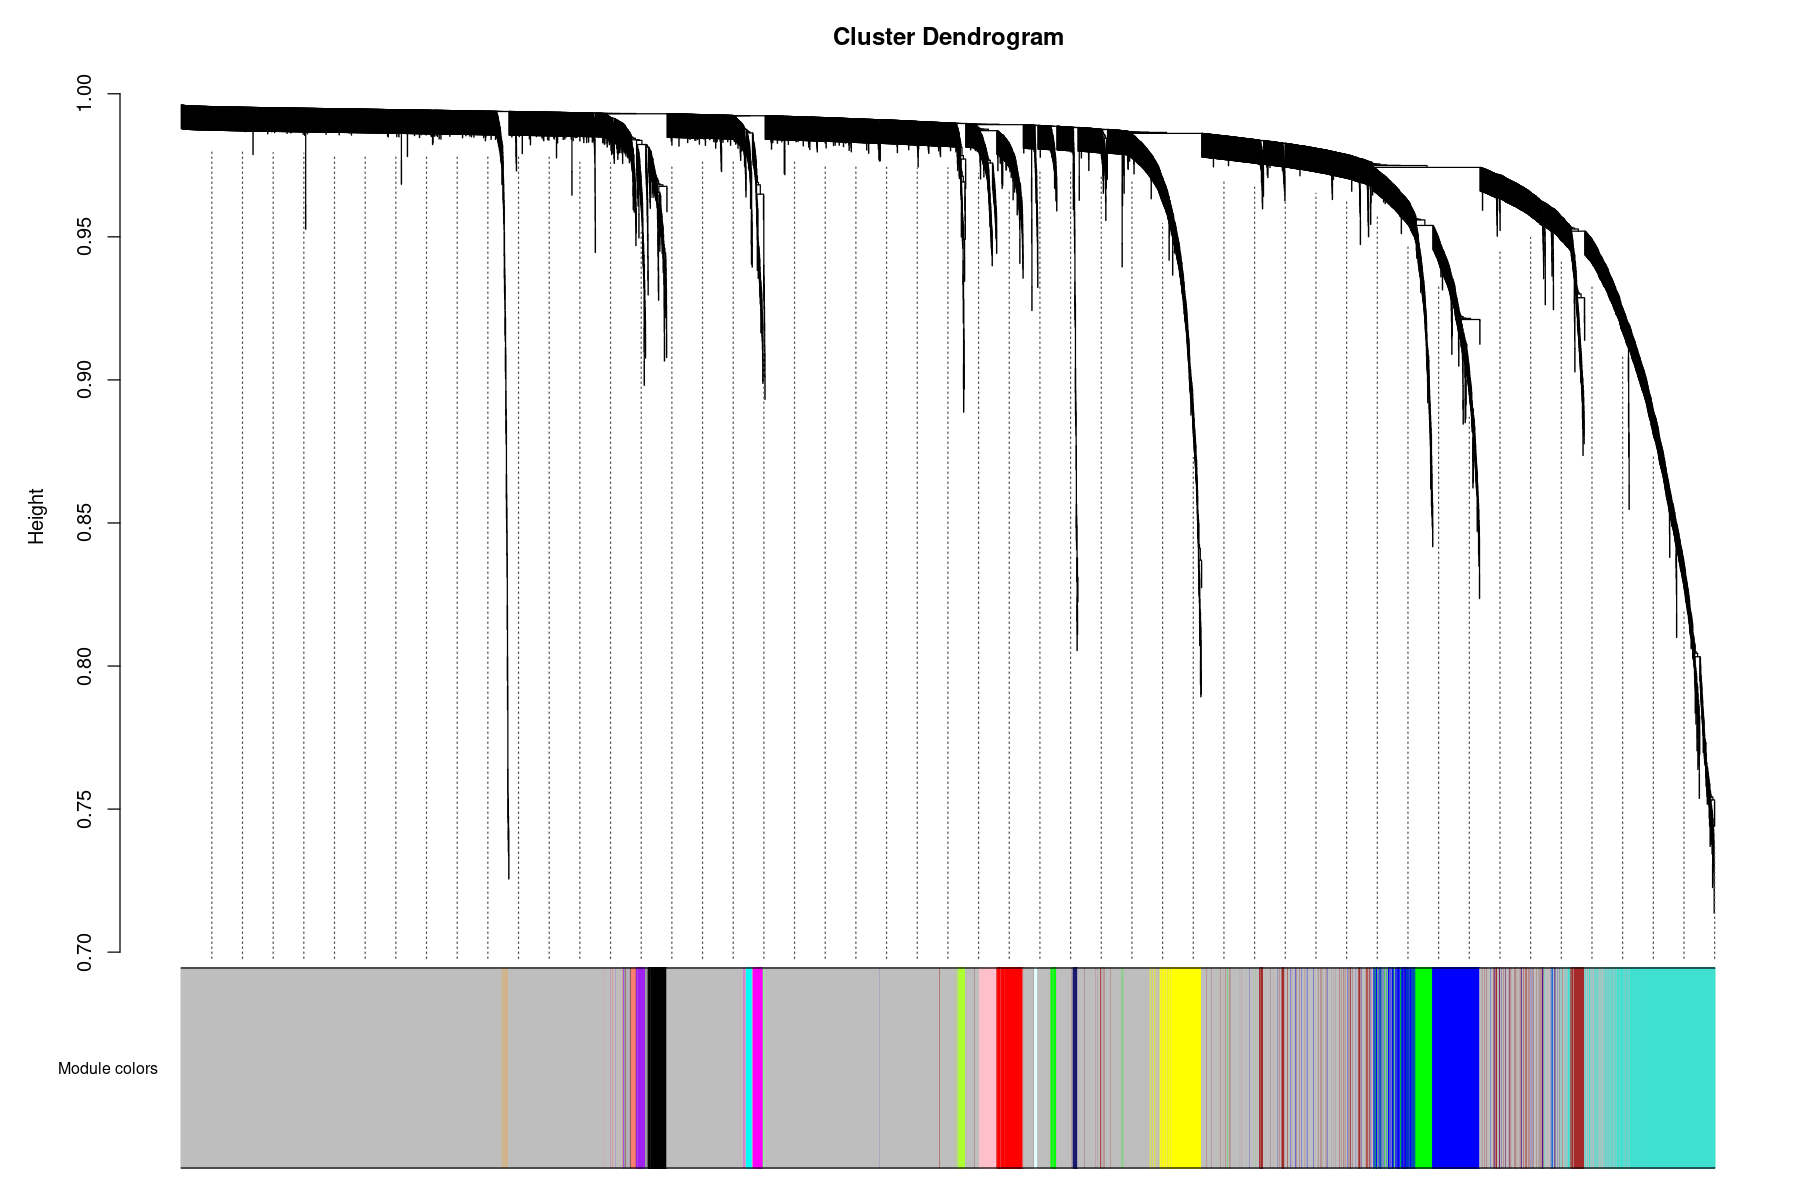

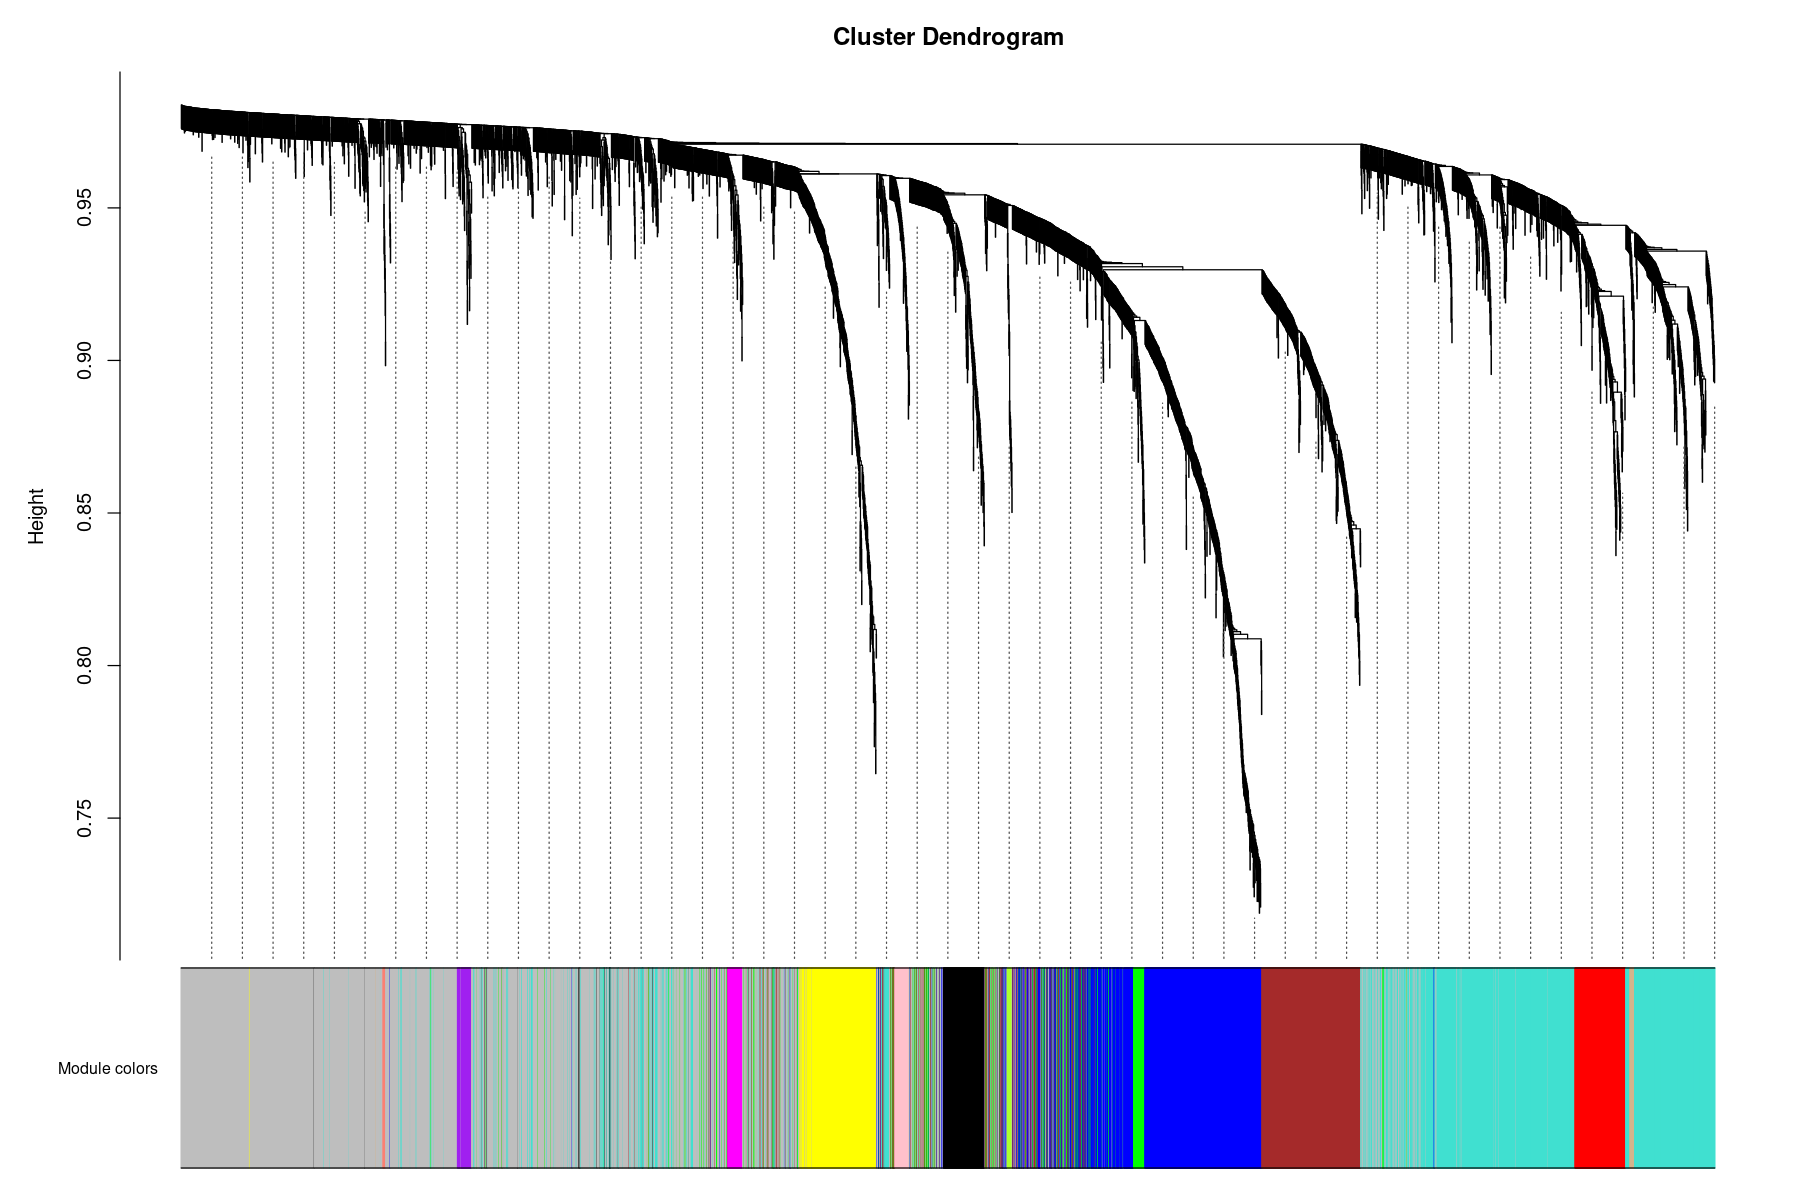

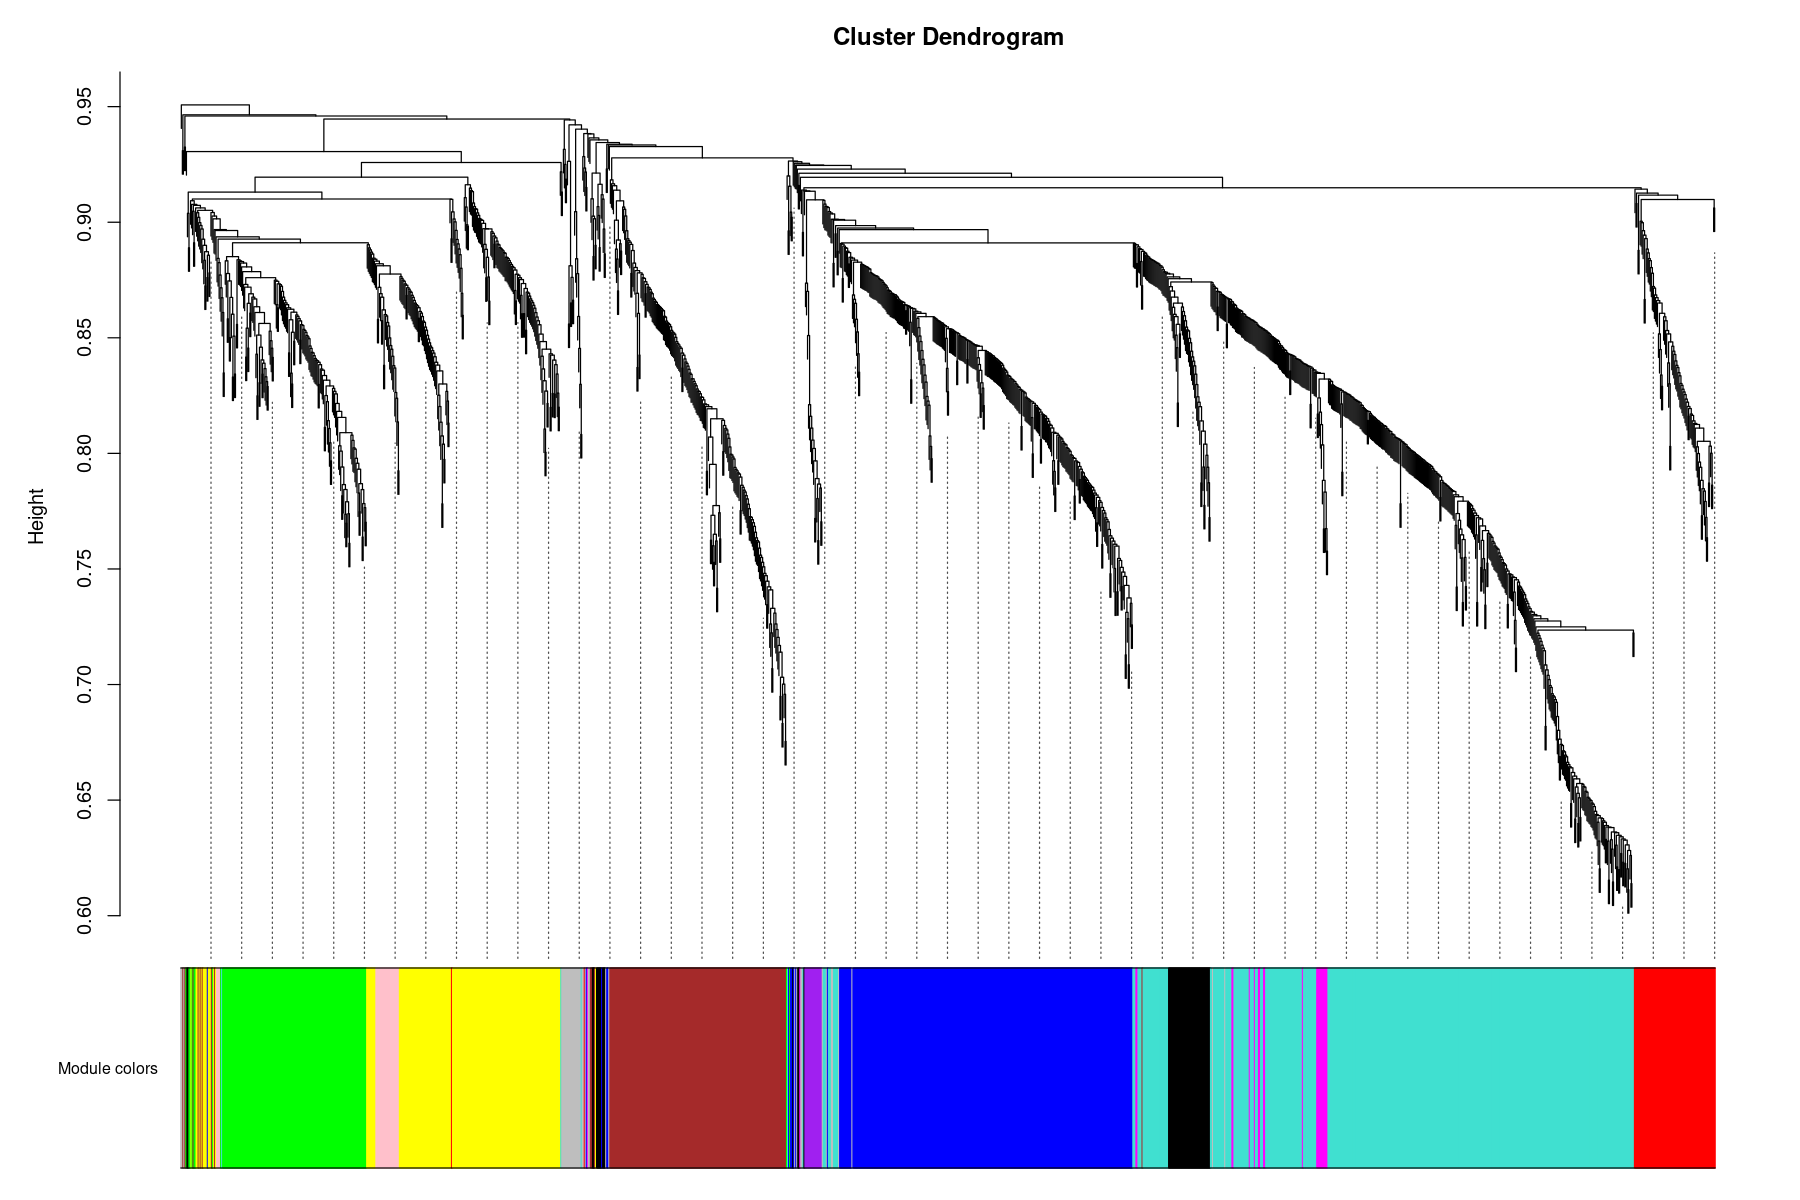

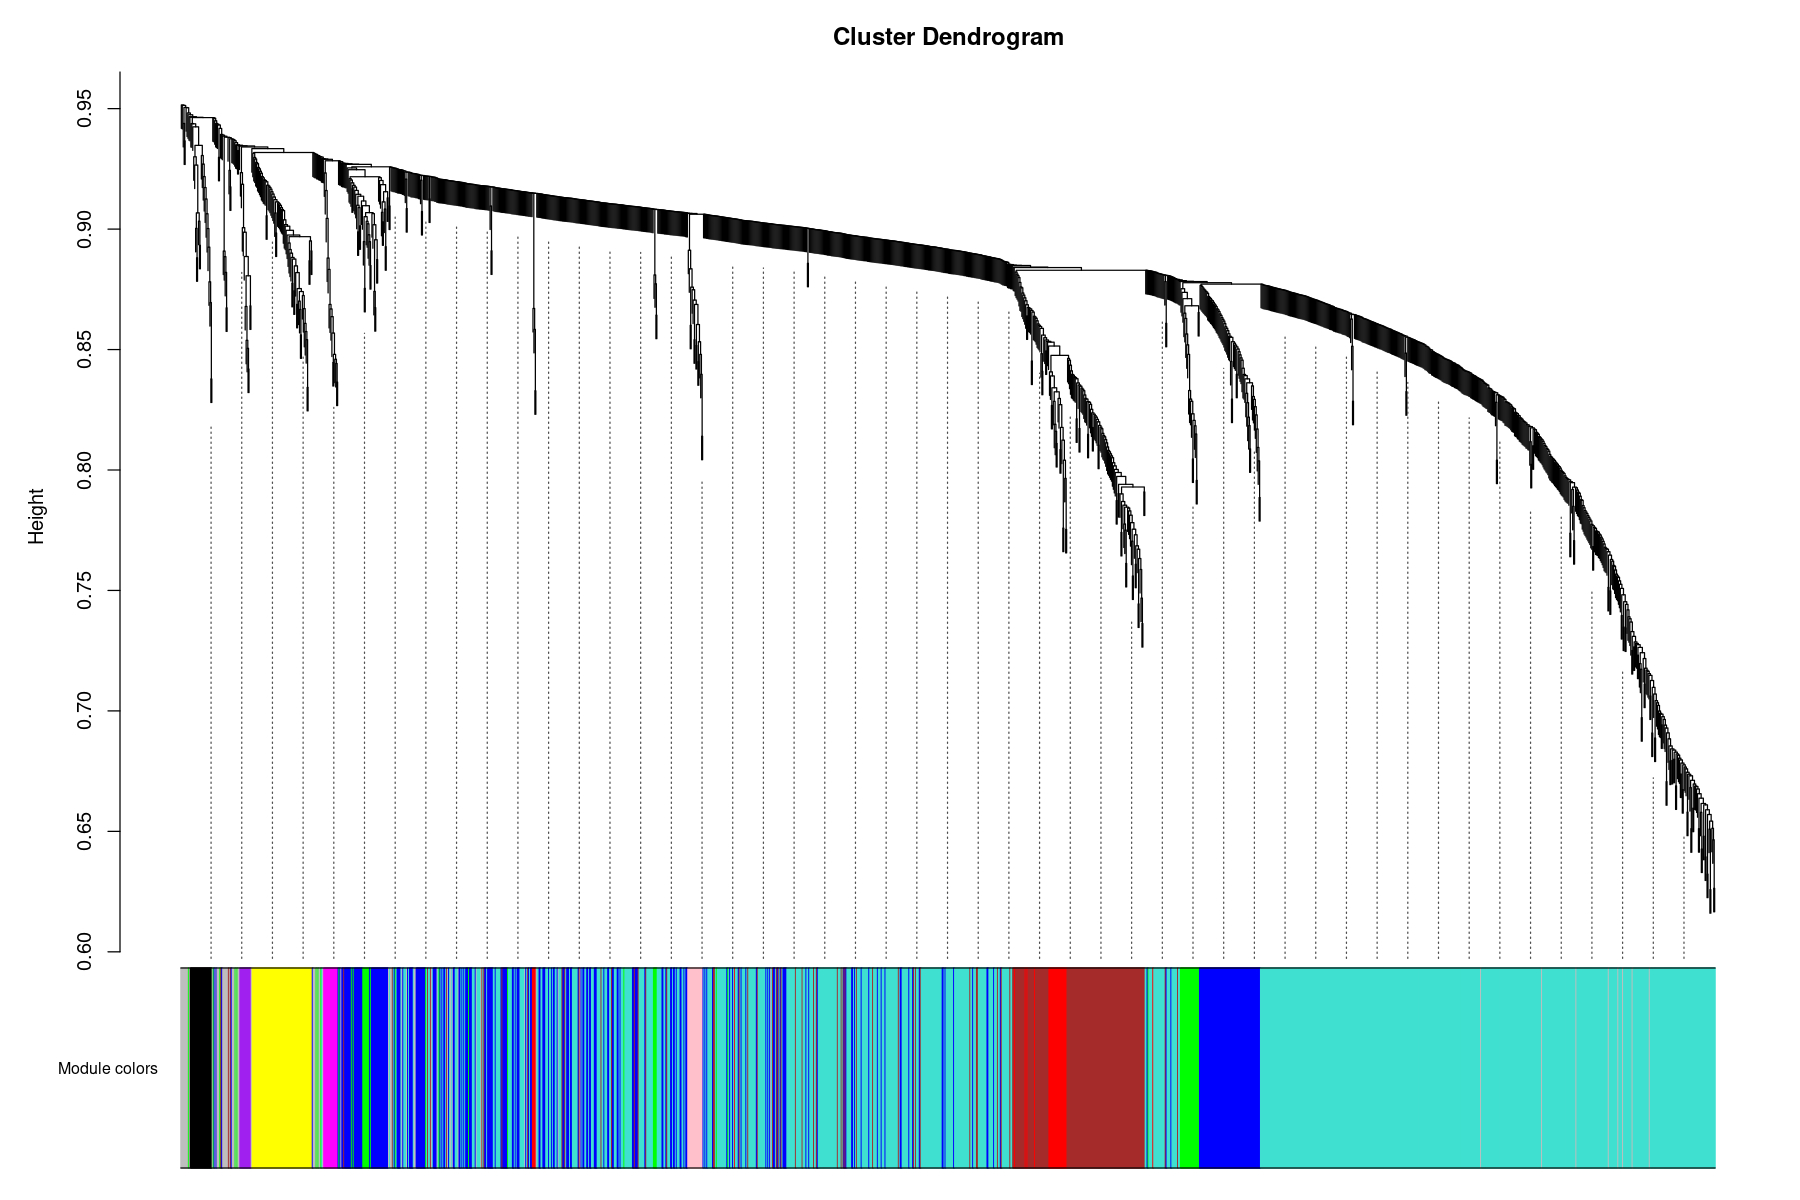

In [86]:
for(netC in blockWise_power2){
    # Convert labels to colors for plotting
    mergedColors = labels2colors(netC$colors)
    # Plot the dendrogram and the module colors underneath
    plotDendroAndColors(netC$dendrograms[[1]], mergedColors[netC$blockGenes[[1]]],
    "Module colors",
    dendroLabels = FALSE, hang = 0.03,
    addGuide = TRUE, guideHang = 0.05)
}

In [174]:
llply(blockWise_power2_spearman[c("body_high", "head_high")], function(x) table(x$colors))

$body_high

   0    1    2    3    4    5    6    7    8    9   10 
3001 1447  680  114   81   69   65   23   22   20   11 

$head_high

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2249  693  622  339  276  222  163  160  127   99   99   98   87   82   78   72 
  16   17   18   19 
  54   32   20   12 


In [25]:
datExpr = expr_list$head_high
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

moduleColors = blockWise_power2$head_high$colors

# Recalculate module eigengenes
MEs = moduleEigengenes(datExpr, moduleColors)$eigengenes
# Add the weight to existing module eigengenes
MET = orderMEs(MEs)
# Plot the relationships among the eigengenes and the trait
#sizeGrWindow(5,7.5);
#par(cex = 0.9)

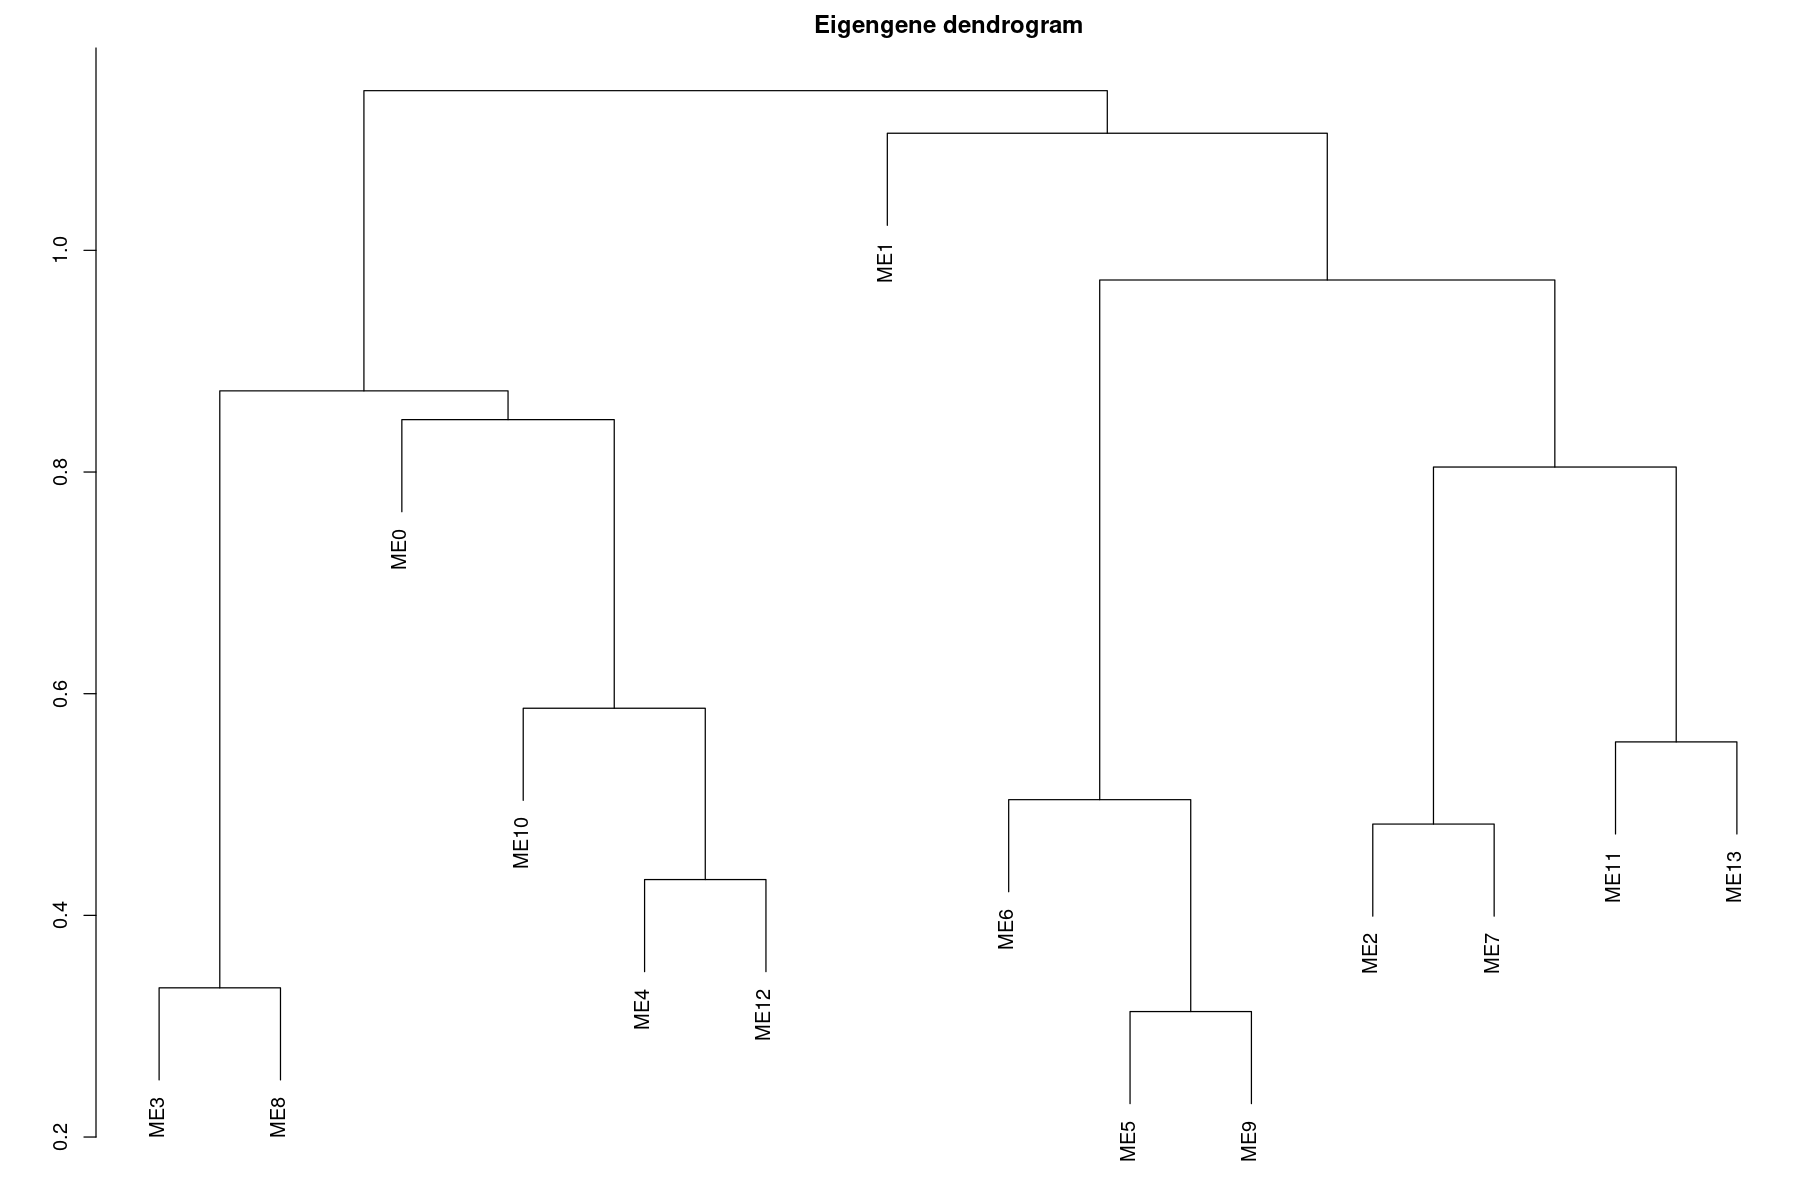

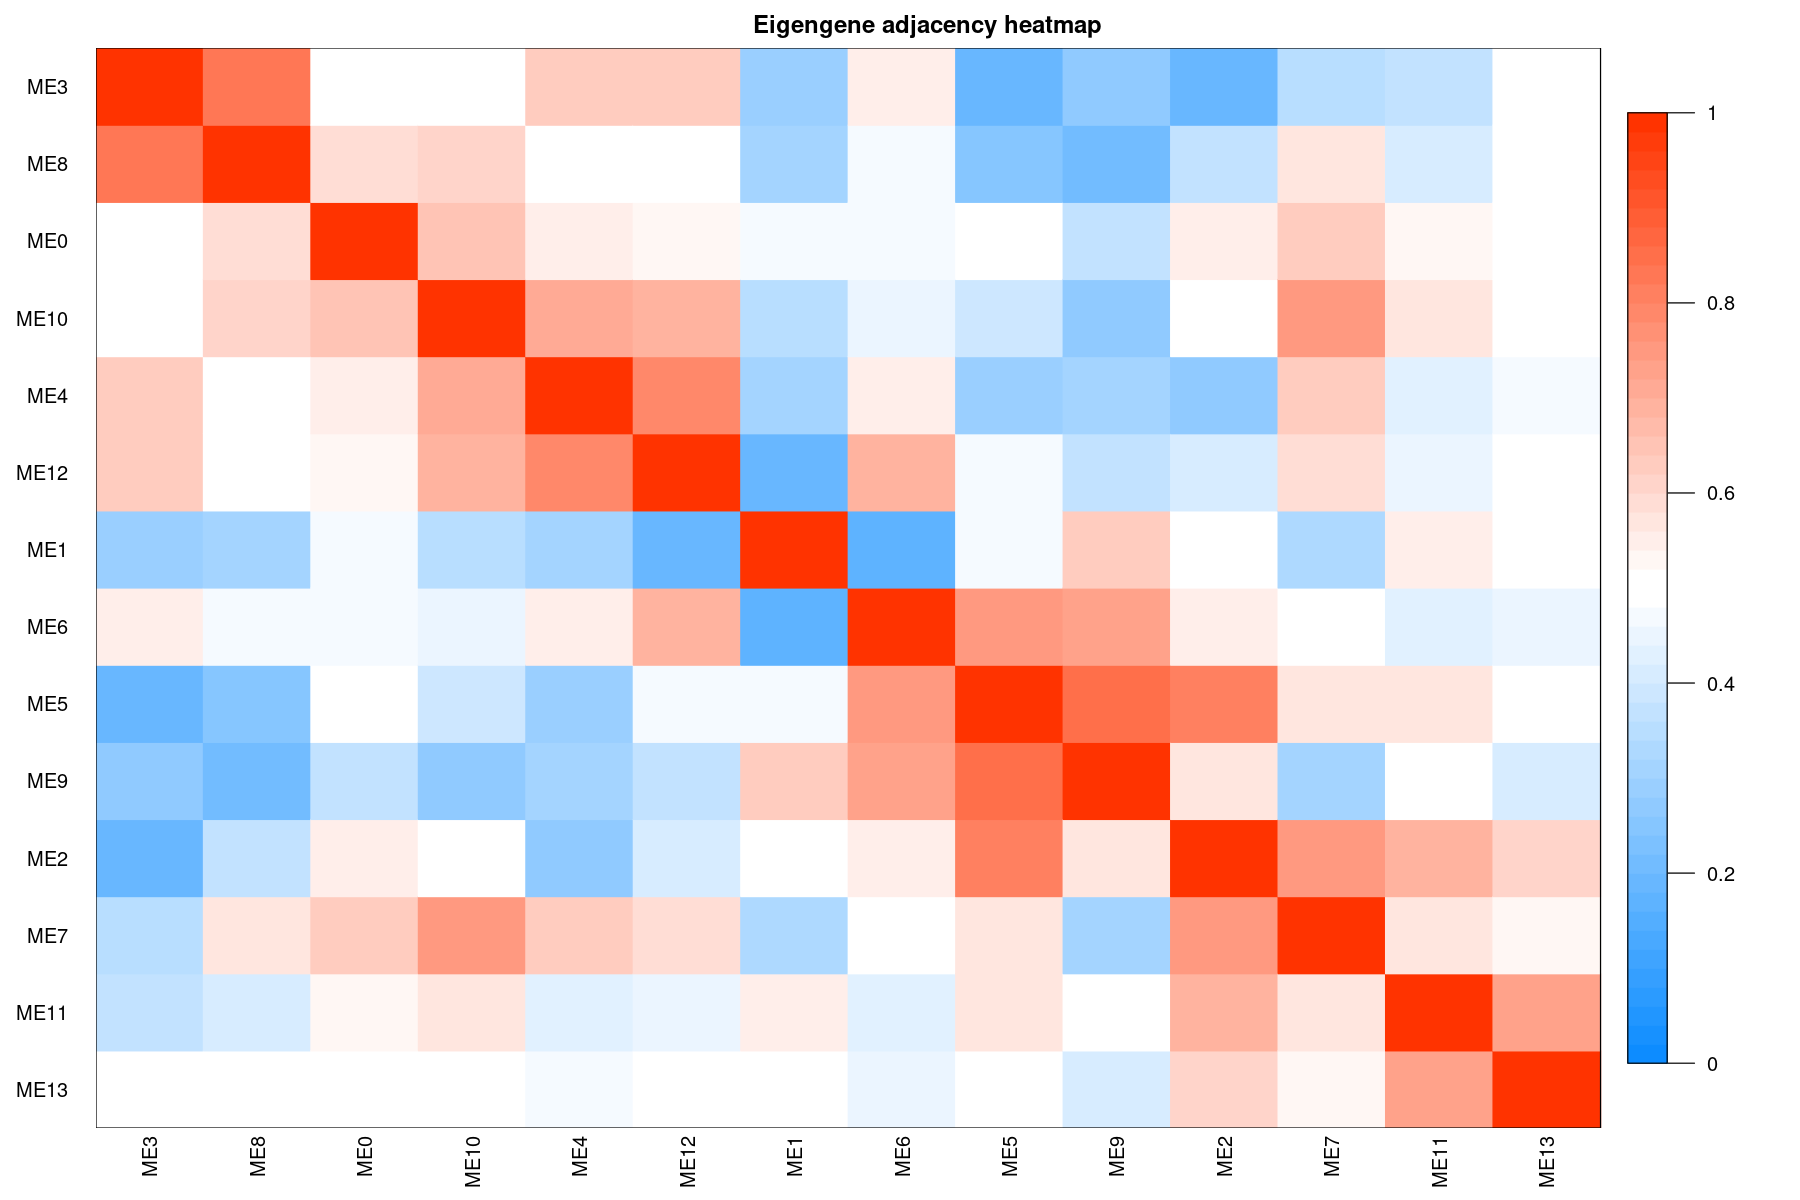

In [26]:
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
plotHeatmaps = FALSE)
# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(3,4,2,2),
plotDendrograms = FALSE, xLabelsAngle = 90)

In [167]:
dissTOM_list_bicor = llply(expr_list, function(datExpr) 1-TOMsimilarityFromExpr(datExpr,
                                                                                networkType = "signed", 
                                                                                power = 2, 
                                                                                corType = "bicor", ), 
                           .parallel = TRUE)

In [163]:
ds = 2; minModSize = 30; dthresh = 0.1; pam = FALSE;

hadj <- Hadjacency(datExpr=expr_list[["body_high"]],type='hybrid2',power=1, corFnc='bicor')
htom <- TOMsimilarity(hadj, TOMType = "unsigned", verbose = 1)
tree = hclust(1-as.dist(htom), method="average")
cut = cutreeHybrid(dendro = tree, pamStage=pam, minClusterSize= minModSize, cutHeight = 0.99999,
                   deepSplit=ds, distM=as.matrix(1-htom))
merged = mergeCloseModules(exprData=expr_list[["body_high"]], colors =  cut$labels, cutHeight=dthresh)
hcolor <-labels2colors(merged$colors)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.1
 mergeCloseModules: less than two proper modules.
  ..color levels are 1
  ..there is nothing to merge.
   Calculating new MEs...


In [166]:
table(hcolor)

hcolor
turquoise 
     5533 

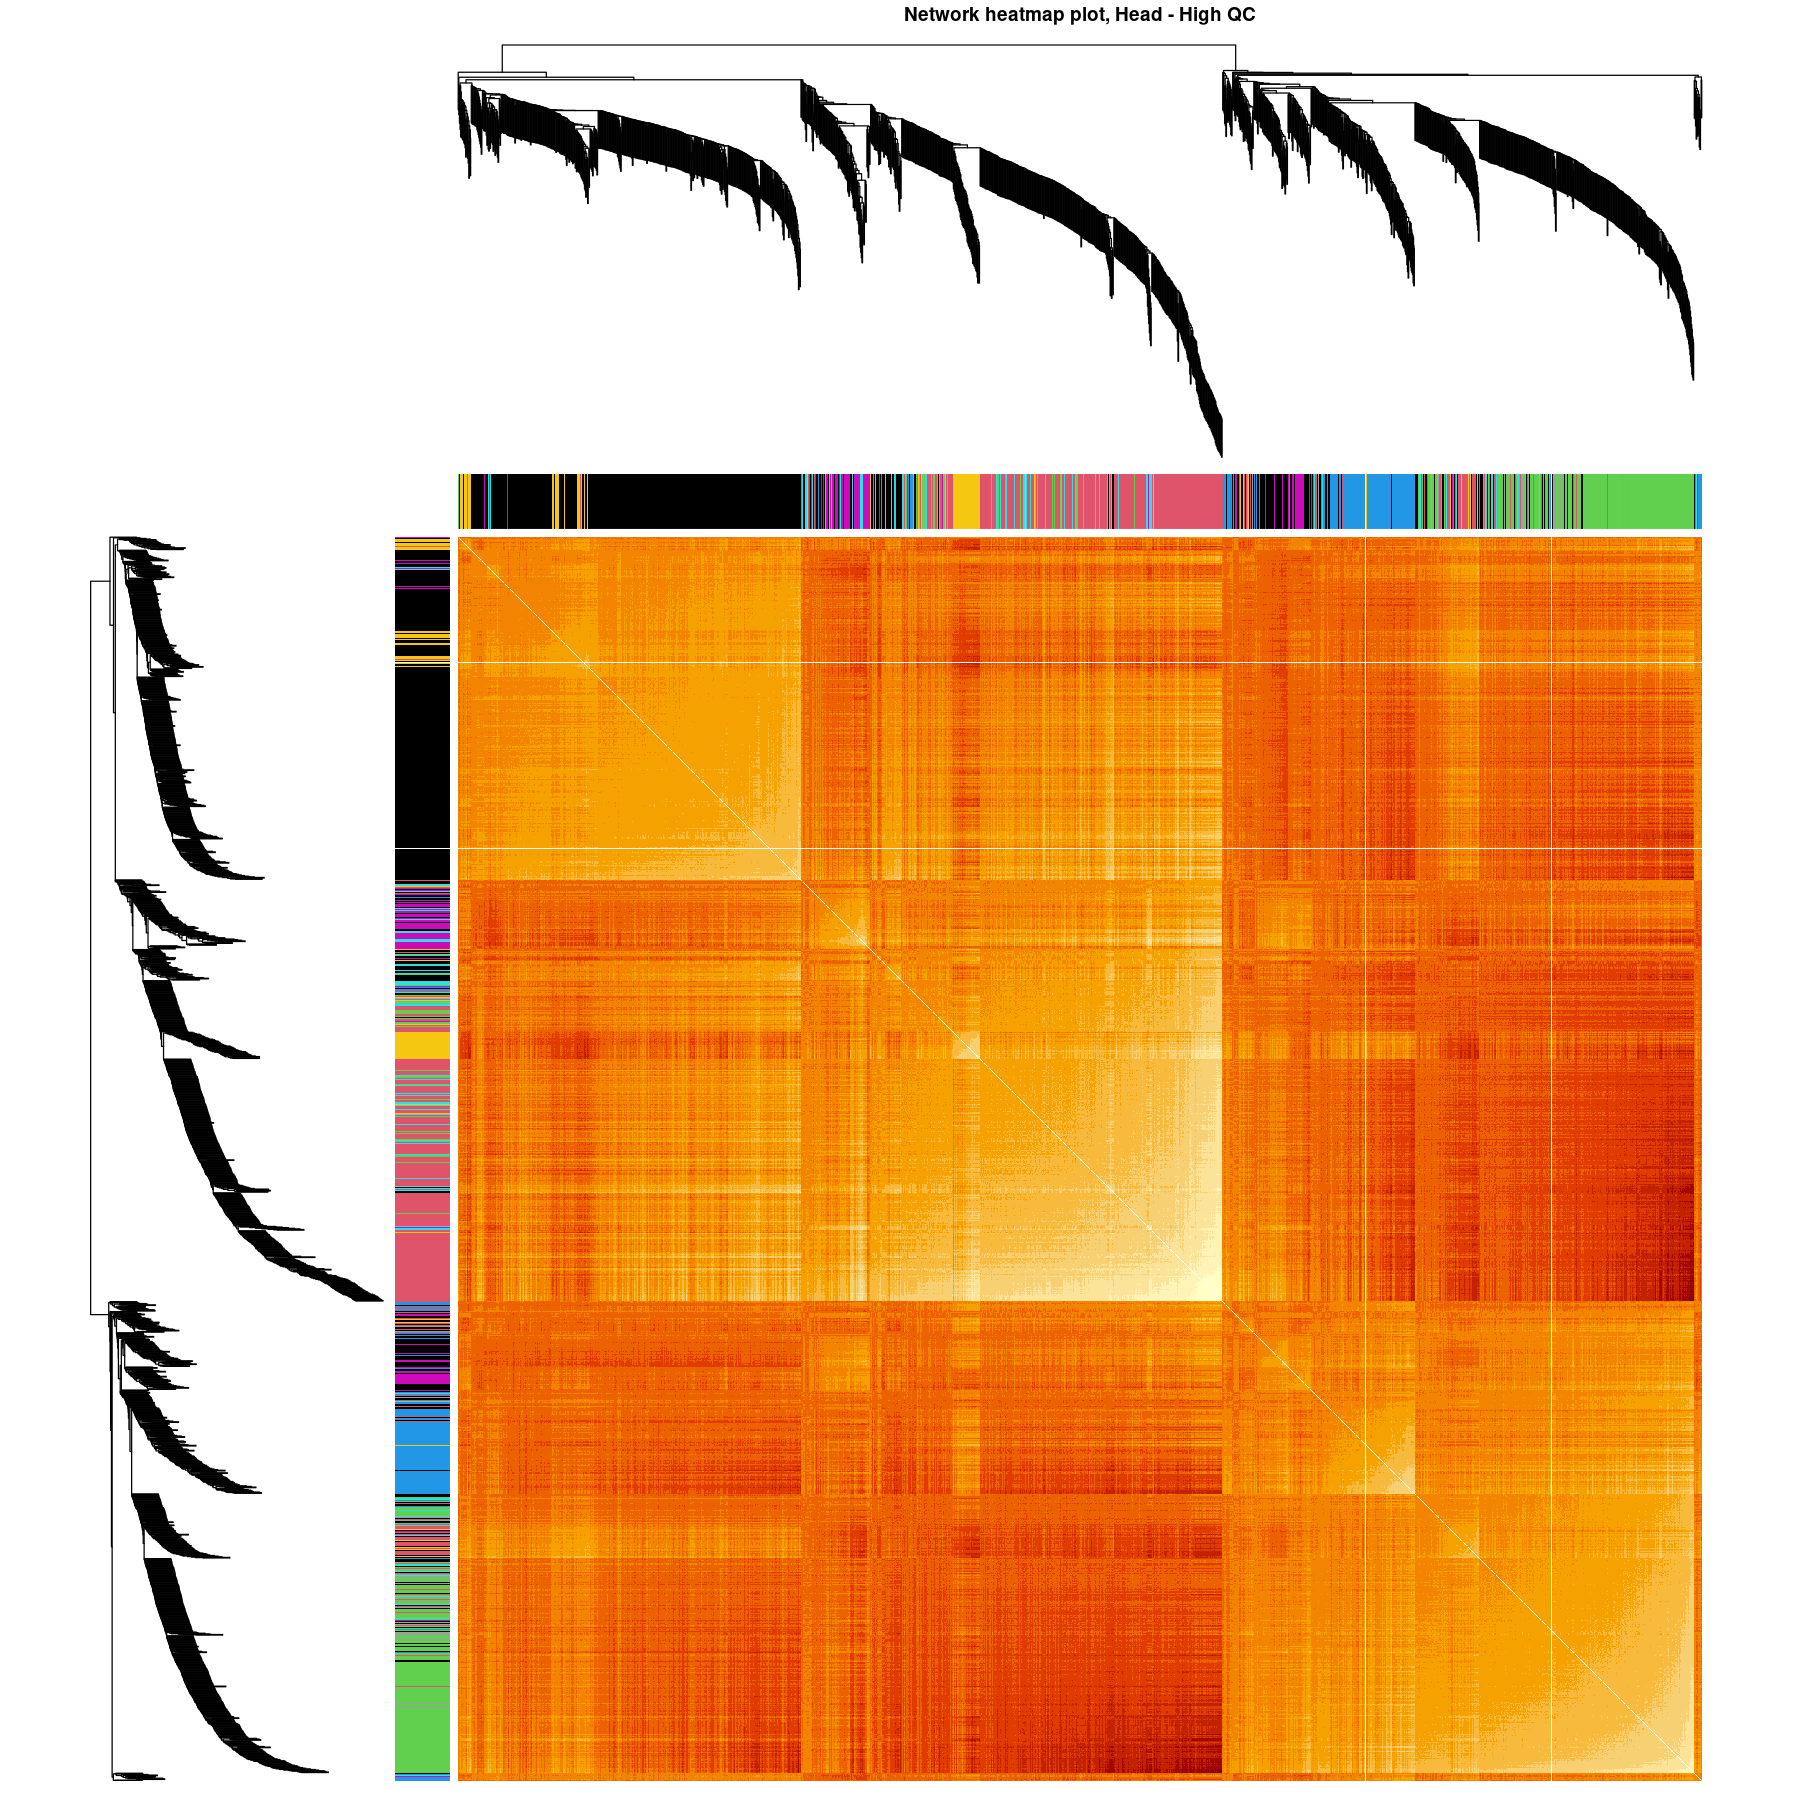

In [172]:
options(repr.plot.width=15, repr.plot.height=15)

data_index = "head_high"

nGenes = ncol(expr_list[[data_index]])
nSamples = nrow(expr_list[[data_index]])
dissTOM = dissTOM_list_bicor[[data_index]]

nSelect = 2000
select = sample(nGenes, size = nSelect);
moduleColors = blockWise_power2[[data_index]]$colors
select = sample(which(moduleColors != 0), size = nSelect)

selectTOM = dissTOM[select, select];
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, 
        main = "Network heatmap plot, Head - High QC")

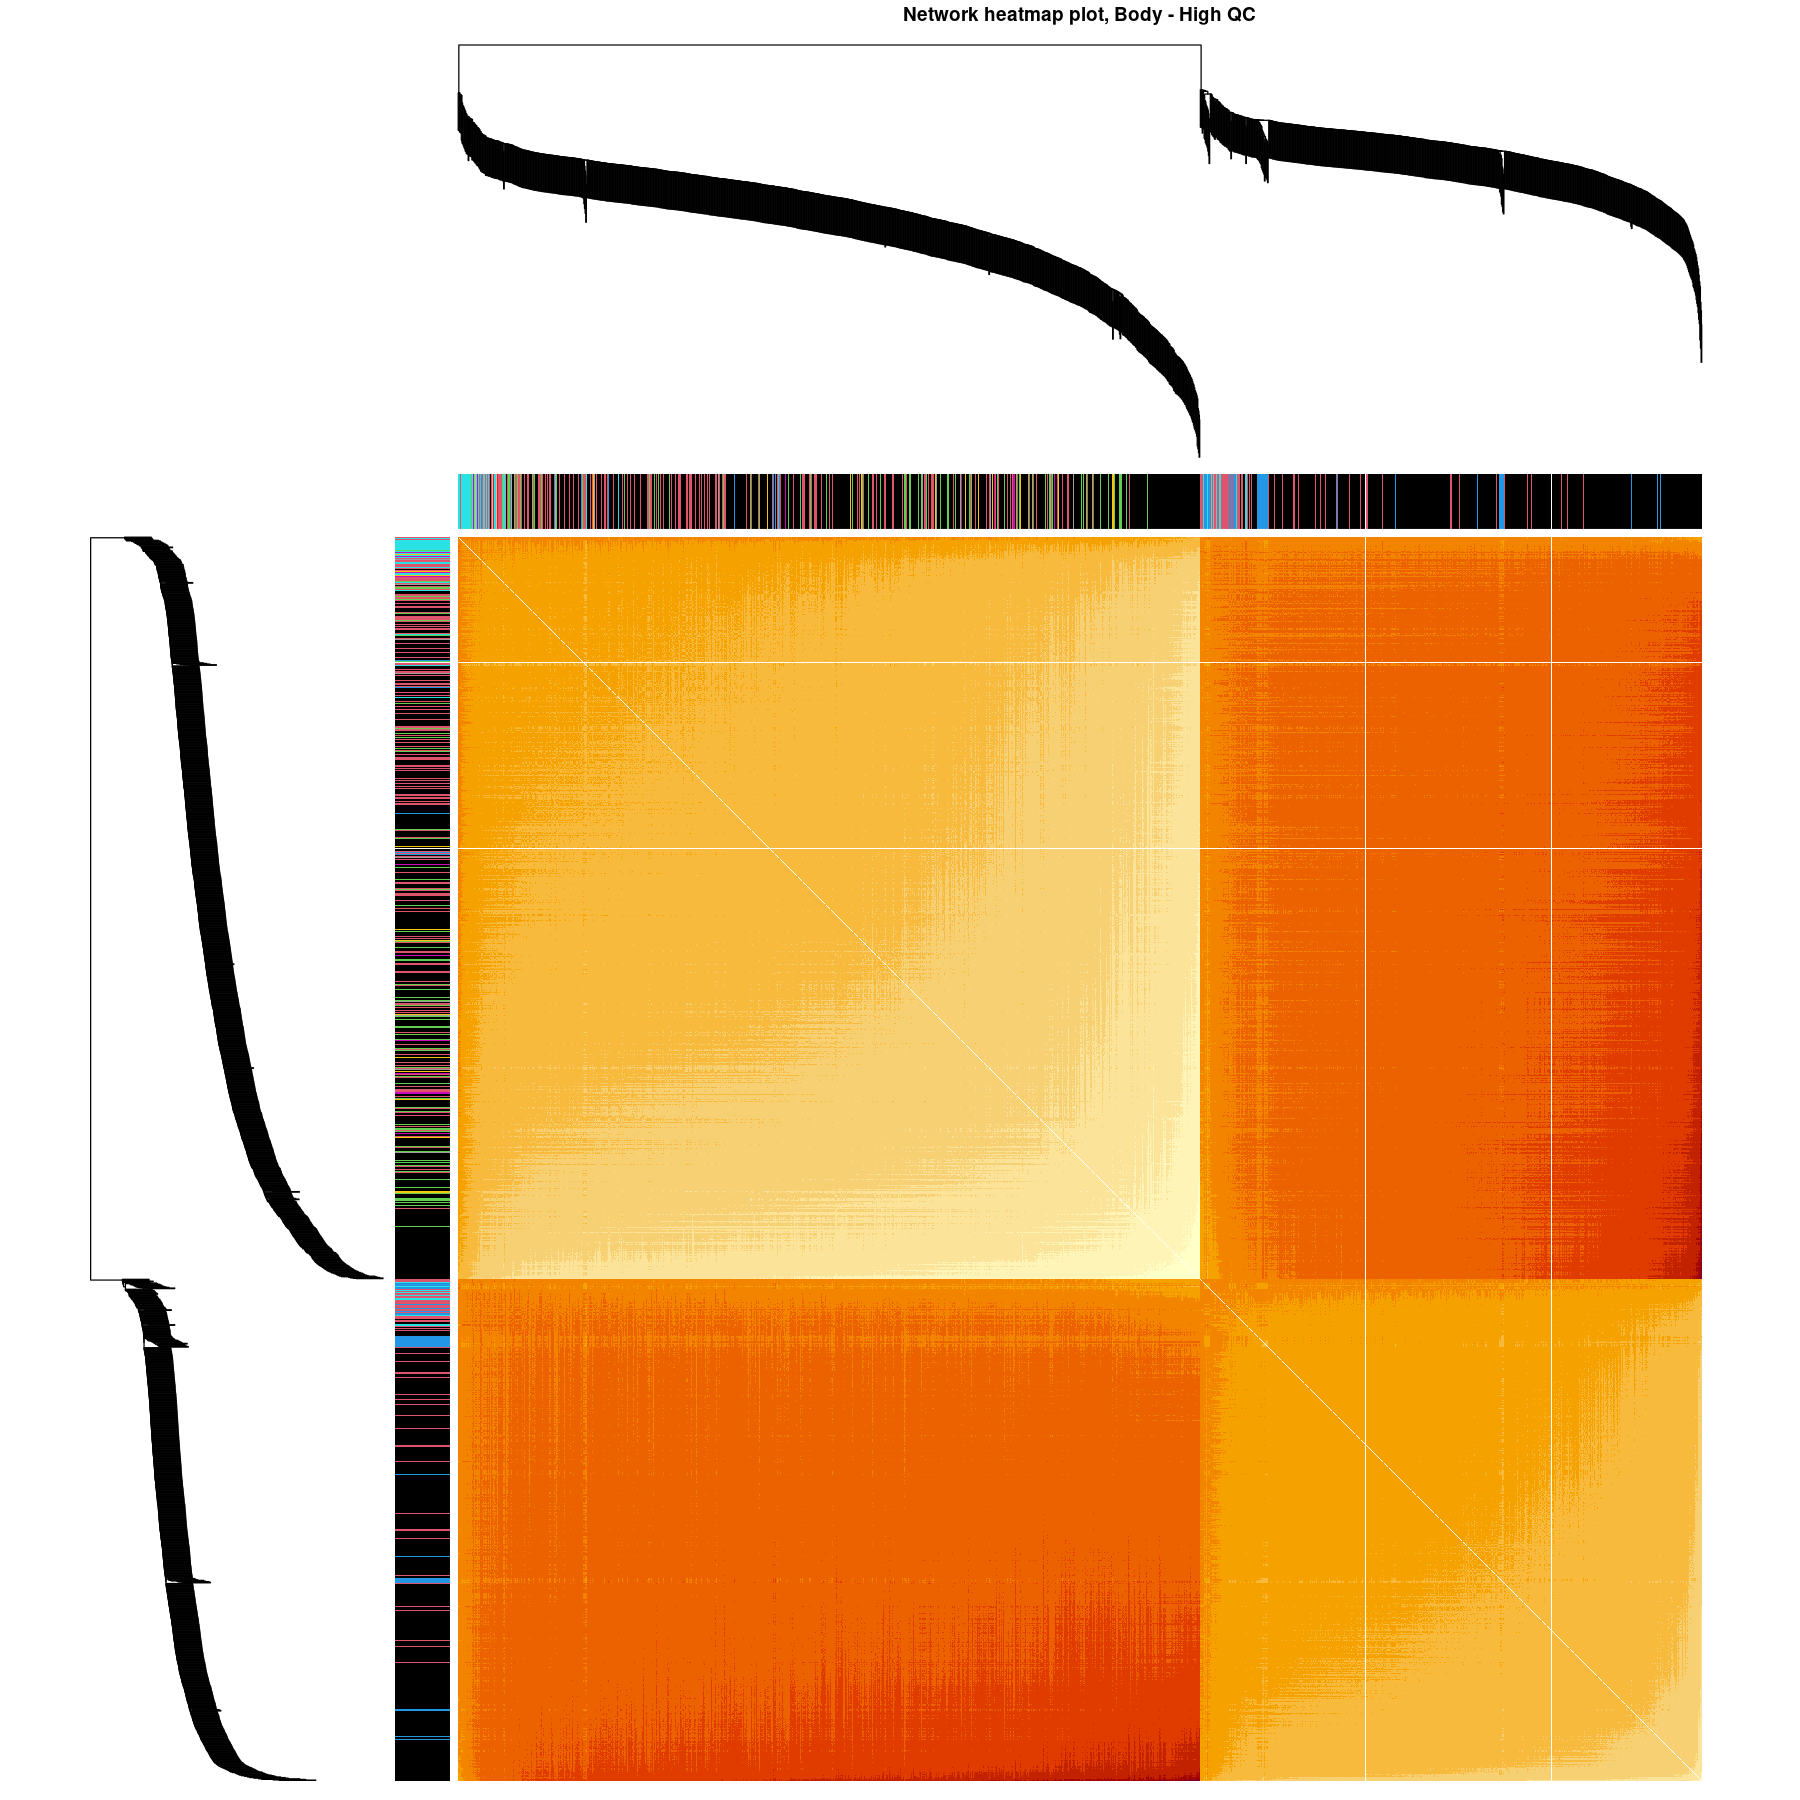

In [173]:
options(repr.plot.width=15, repr.plot.height=15)

data_index = "body_high"

nGenes = ncol(expr_list[[data_index]])
nSamples = nrow(expr_list[[data_index]])
dissTOM = dissTOM_list_bicor[[data_index]]

nSelect = 2000
select = sample(nGenes, size = nSelect);
moduleColors = blockWise_power2[[data_index]]$colors
select = sample(which(moduleColors != 0), size = nSelect)

selectTOM = dissTOM[select, select];
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, 
        main = "Network heatmap plot, Body - High QC")

In [107]:
data.frame(genes = names(blockWise_power2$body_high$colors),
           modules = blockWise_power2$body_high$colors) %>% head

,genes,modules
,<chr>,<dbl>
FBgn0052350,FBgn0052350,0
FBgn0024733,FBgn0024733,1
FBgn0040372,FBgn0040372,1
FBgn0023536,FBgn0023536,0
FBgn0023537,FBgn0023537,1
FBgn0029525,FBgn0029525,0


In [108]:
label = "head_high"
getModules = function(label) {
    x = blockWise_power2[[label]]
    tissue =  str_split(label, "_")[[1]][1]
    QC = str_split(label, "_")[[1]][2]
    data.frame(Gene = names(x$colors),
               WGCNA_modules = x$colors,
               tissue = tissue,
               QC = QC)
    }
(WGCNA_modules = ldply(names(blockWise_power2), getModules))
write_csv(WGCNA_modules, file = "../data/WGCNA_modules_bodyHead_Control.csv")

Gene,WGCNA_modules,tissue,QC
<chr>,<dbl>,<chr>,<chr>
FBgn0031081,0,body,low
FBgn0031080,0,body,low
FBgn0053217,0,body,low
FBgn0052350,0,body,low
FBgn0024733,2,body,low
FBgn0040372,1,body,low
FBgn0000316,0,body,low
FBgn0029524,0,body,low
FBgn0023536,0,body,low


In [109]:
Head_hsbm = read_csv("../data//1502genes-Control_Head-hsbm-fit_df.csv")
Head_hsbm$X1 = NULL
Head_hsbm$tissue = "head"
Head_hsbm$QC = "trimmed"
Head_hsbm$B1 = as.numeric(factor(Head_hsbm$B1))
Head_hsbm$B2 = as.numeric(factor(Head_hsbm$B2))
Head_hsbm$B3 = as.numeric(factor(Head_hsbm$B3))
Head_hsbm$B4 = as.numeric(factor(Head_hsbm$B4))
Head_hsbm$B5 = as.numeric(factor(Head_hsbm$B5))

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  Gene = col_character(),
  Degree = col_double(),
  E_corr = col_double(),
  B1 = col_double(),
  B2 = col_double(),
  B3 = col_double(),
  B4 = col_double(),
  B5 = col_double()
)




In [110]:
Body_hsbm = read_csv("../data//1610genes-Control_Body-hsbm-fit_df.csv")
Body_hsbm$X1 = NULL
Body_hsbm$tissue = "body"
Body_hsbm$QC = "trimmed"
Body_hsbm$B1 = as.numeric(factor(Body_hsbm$B1))
Body_hsbm$B2 = as.numeric(factor(Body_hsbm$B2))
Body_hsbm$B3 = as.numeric(factor(Body_hsbm$B3))
Body_hsbm$B4 = as.numeric(factor(Body_hsbm$B4))
Body_hsbm$B5 = as.numeric(factor(Body_hsbm$B5))

hsbm = rbind(Body_hsbm, Head_hsbm)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  Gene = col_character(),
  Degree = col_double(),
  E_corr = col_double(),
  B1 = col_double(),
  B2 = col_double(),
  B3 = col_double(),
  B4 = col_double(),
  B5 = col_double()
)




In [113]:
full_join(WGCNA_modules, hsbm, by = c("Gene", "tissue", "QC")) %>%
    filter(QC == "trimmed") %>%
    write_csv(file = "../data/WGCNA_Hierarchical-SBM_modules_Body-Head_Control_HighQC_Trimmed.csv")

In [114]:
full_join(WGCNA_modules, hsbm, by = c("Gene", "tissue", "QC")) %>%
    filter(QC == "trimmed")

Gene,WGCNA_modules,tissue,QC,Degree,E_corr,B1,B2,B3,B4,B5
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FBgn0024733,1,head,trimmed,131,0.4972895,37,19,5,3,1
FBgn0023537,1,head,trimmed,31,0.4327748,26,4,2,3,1
FBgn0000108,2,head,trimmed,150,0.4697307,68,22,4,2,1
FBgn0002579,1,head,trimmed,154,0.5367797,48,7,3,3,1
FBgn0026879,1,head,trimmed,46,0.4219260,61,19,5,3,1
FBgn0040349,9,head,trimmed,19,0.4459602,20,16,2,3,1
FBgn0052813,5,head,trimmed,5,0.4133892,44,6,8,3,1
FBgn0003517,1,head,trimmed,117,0.5211287,39,7,3,3,1
FBgn0025626,4,head,trimmed,1,0.4087919,29,14,1,1,1
